In [ ]:
## Mount google drive - Click on the link and give authorization
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install selenium

     |████████████████████████████████| 911kB 6.6MB/s 


In [ ]:
import sys
import os

In [ ]:
projDir = '/content/drive/MyDrive/github_projects/'

if not os.path.exists(projDir):
  os.makedirs(projDir)

%cd $projDir
%ls

/content/drive/MyDrive/github_projects
airbnb_seatle/  app/  miniconda/  README.md


In [ ]:
!git init .
!git clone https://github.com/oliveirampo/dog_breed_classification.git


Reinitialized existing Git repository in /content/drive/MyDrive/github_projects/.git/
Cloning into 'dog_breed_classification'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 138 (delta 18), reused 38 (delta 16), pack-reused 97
Receiving objects: 100% (138/138), 695.08 MiB | 23.51 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Checking out files: 100% (29/29), done.


In [ ]:
!git pull https://github.com/oliveirampo/dog_breed_classification.git

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 2), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/oliveirampo/dog_breed_classification
 * branch            HEAD       -> FETCH_HEAD
Updating 5d09962..2f29cdb
Fast-forward
 app/data/inp/categories.json | 1 +
 1 file changed, 1 insertion(+)
 create mode 100644 app/data/inp/categories.json


In [ ]:
scrDir = projDir + 'dog_breed_classification/app/scr'
%cd $scrDir
%ls

/content/drive/MyDrive/github_projects/dog_breed_classification/app/scr
download_image.py  plot.py       train_model.ipynb
__init__.py        __pycache__/  train_model.py


In [ ]:
import train_model

In [ ]:
n_splits = 6
dataset_directory = projDir + 'dog_breed_classification/app/data/inp'

categories, x_train, x_valid, x_test, train_targets, valid_targets, test_targets = \
train_model.load_compressed_dataset(n_splits, dataset_directory)


Loading compressed data...


In [ ]:
print(len(categories))
print(x_train.shape)
print(train_targets.shape)

114
(4920, 224, 224, 3)
(4920, 114)


In [ ]:
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from keras.layers import GlobalAvgPool2D
from keras.layers import Dense, Flatten

from tensorflow.keras.optimizers import SGD

import numpy as np


In [ ]:
def train_transfer_learning_vgg(x_train, y_train, x_validation, y_validation):
    """Fine tune pretrained VGG model."""

    base_model = VGG16(weights='imagenet', include_top=False)
    # print(base_model.summary())

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAvgPool2D()(x)
    # let's add a fully-connect layer
    x = Dense(1024, activation='relu')(x)
    # add a logistic layer -- with correct number of classes
    predictions = Dense(y_train.shape[1], activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # print(model.summary())

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional layers of the model
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    # train the model on the new fata for a few epochs
    model.fit(x_train, y_train, epochs=2, validation_data=(x_validation, y_validation), verbose=1, shuffle=True)
    # model.fit(train_vgg16, train_targets, epochs=20, validation_data=(valid_vgg16, valid_targets),
    #           callbacks=[checkpointer], verbose=1, shuffle=True)

    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from vgg16. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:15]:
        layer.trainable = False
    for layer in model.layers[15:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    history = model.fit(x_train, y_train, epochs=2, validation_data=(x_validation, y_validation), verbose=1, shuffle=True)
    
    return model, history
    

In [ ]:
model, history = train_transfer_learning_vgg(x_train, train_targets, x_valid, valid_targets)

Epoch 1/2
154/154 [==============================] - 27s 171ms/step - loss: 4.7359 - accuracy: 0.0224 - val_loss: 4.8259 - val_accuracy: 0.0013
Epoch 2/2
154/154 [==============================] - 26s 169ms/step - loss: 4.1210 - accuracy: 0.0918 - val_loss: 4.4938 - val_accuracy: 0.0474
0 input_4
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/2
154/154 [==============================] - 31s 198ms/step - loss: 3.4269 - accuracy: 0.1927 - val_loss: 4.1822 - val_accuracy: 0.0692
Epoch 2/2
154/154 [==============================] - 30s 196ms/step - loss: 2.9844 - accuracy: 0.2724 - val_loss: 4.0629 - val_accuracy: 0.0859


In [ ]:
model_path = projDir + 'dog_breed_classification/app/model'
model_path

'/content/drive/MyDrive/github_projects/dog_breed_classification/app/model'

In [ ]:
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/github_projects/dog_breed_classification/app/model/assets


In [ ]:
# reconstruct the trained model
model = load_model(model_path)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


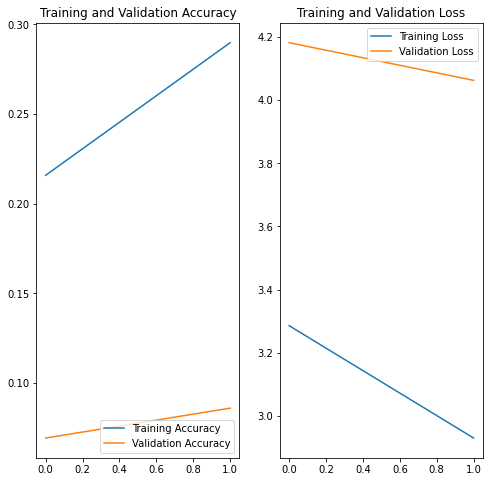

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(x_test, test_targets)

36/36 [==============================] - 5s 142ms/step - loss: 3.8022 - accuracy: 0.1553


[3.8022327423095703, 0.15526315569877625]

In [ ]:
test_image_path = projDir + 'dog_breed_classification/app/static/images/test_image.jpg'
%ls $test_image_path

/content/drive/MyDrive/github_projects/dog_breed_classification/app/static/images/test_image.jpg


In [ ]:
def classify_image(img_path, model, top=3):
    """Example from Keras of how to classify single image with ResNet50."""

    # model = VGG16(weights='imagenet')

    img = image.load_img(img_path, target_size=(224, 224))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)[0]
    
    top_indices = features.argsort()[-top:][::-1]
    results = [{"breed": categories[str(i)], "percentage": '{:.2f}'.format(features[i] * 100.0)} for i in top_indices]
    return results

In [ ]:
results = classify_image(test_image_path, model)
results

[{'breed': 'border_terrier', 'percentage': '100.00'},
 {'breed': 'english_setter', 'percentage': '0.00'},
 {'breed': 'cocker_spaniel', 'percentage': '0.00'}]

# Compute accuracy of VGG16 model with test images.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import numpy as np

In [ ]:
projDir = '/content/drive/MyDrive/github_projects/'
test_image_path = projDir + 'dog_breed_classification/app/static/images/test_image.jpg'

In [ ]:
%ls $projDir

airbnb_seatle/  app/  dog_breed_classification/  miniconda/  README.md


In [ ]:
def classify_image_vgg16(img_path, model):
    """Example from Keras of how to classify single image with ResNet50."""

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    # print('Predicted:', decode_predictions(features, top=3)[0])
    results = decode_predictions(features, top=3)
    results = [{"breed": res[1], 'percentage': '({:.2f} %)'.format(res[2] * 100.0)} for res in results[0]]
    for res in results: print(res)


In [ ]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
classify_image_vgg16(test_image_path, model)

40960/35363 [==================================] - 0s 0us/step
{'breed': 'golden_retriever', 'percentage': '(70.57 %)'}
{'breed': 'Labrador_retriever', 'percentage': '(29.15 %)'}
{'breed': 'kuvasz', 'percentage': '(0.07 %)'}


In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# model.evaluate(x_test, test_targets)
predictions = model.predict(x_test, batch_size=32)

In [ ]:
dog_breeds = list(categories.values())
print(len(dog_breeds))
print(x_test.shape)
print(predictions.shape)
print(test_targets.shape)

114
(1140, 224, 224, 3)
(1140, 1000)
(1140, 114)


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     